# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
from PIL import Image, ImageFile
#import helper

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform_img = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
    ])
    imagenet_dat = datasets.ImageFolder(data_dir, transform=transform_img)
    data_loader = torch.utils.data.DataLoader(imagenet_dat,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 16
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

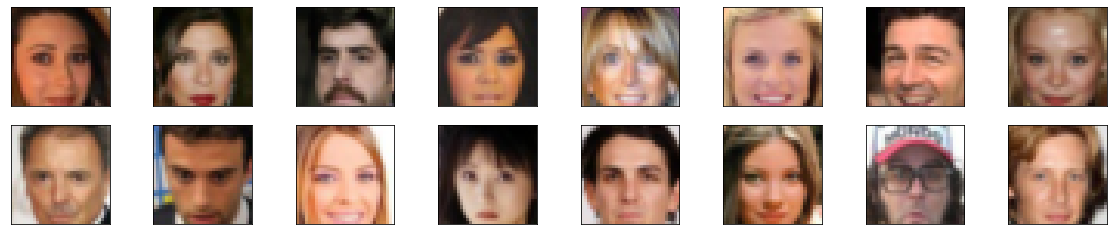

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    minm, maxm = feature_range
    
    x = x * (maxm-minm) + minm
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8431)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv_block(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels,
                          kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = conv_block(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv_block(conv_dim, conv_dim*2, 4)
        self.conv3 = conv_block(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        self.out = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim * 4 * 4 * 4)
        
        x = self.fc(x)
        x = self.dropout(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding,
                                    bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/arf111/.local/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    init_gain = 0.02
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv')!= -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(6

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) * np.random.uniform(0.7, 1.0)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.003, betas=(0.5, 0.999))
# Different learning rate of generator and discriminator...TTUR Paper 
g_optimizer = optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

## Reasons behind different learning rate for generator and discriminator:
The authors of this paper found out that different learning rates for generator and discriminator tends to make the convergence to stationary local nash equilibrium.
https://arxiv.org/abs/1706.08500

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            d_fake_out = D(fake_images)
            d_fake_loss = fake_loss(d_fake_out)
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
#             perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.7507 | g_loss: 4.5099
Epoch [    1/   20] | d_loss: 1.1017 | g_loss: 1.4048
Epoch [    1/   20] | d_loss: 1.2828 | g_loss: 2.3237
Epoch [    1/   20] | d_loss: 1.2457 | g_loss: 2.6411
Epoch [    1/   20] | d_loss: 1.6789 | g_loss: 2.2791
Epoch [    1/   20] | d_loss: 1.3254 | g_loss: 1.3519
Epoch [    1/   20] | d_loss: 1.1774 | g_loss: 0.9611
Epoch [    1/   20] | d_loss: 1.2795 | g_loss: 1.0535
Epoch [    1/   20] | d_loss: 1.2518 | g_loss: 1.2001
Epoch [    1/   20] | d_loss: 1.2514 | g_loss: 1.2978
Epoch [    1/   20] | d_loss: 1.2518 | g_loss: 1.3131
Epoch [    1/   20] | d_loss: 1.1905 | g_loss: 1.0441
Epoch [    1/   20] | d_loss: 1.3454 | g_loss: 1.0091
Epoch [    1/   20] | d_loss: 1.1443 | g_loss: 1.3297
Epoch [    1/   20] | d_loss: 1.2437 | g_loss: 0.9348
Epoch [    1/   20] | d_loss: 1.1920 | g_loss: 1.2075
Epoch [    1/   20] | d_loss: 1.1972 | g_loss: 1.1453
Epoch [    1/   20] | d_loss: 1.3244 | g_loss: 1.3247
Epoch [    1/   20] | d_loss

Epoch [    2/   20] | d_loss: 1.6944 | g_loss: 0.6949
Epoch [    2/   20] | d_loss: 1.1785 | g_loss: 1.2444
Epoch [    2/   20] | d_loss: 1.2988 | g_loss: 0.9613
Epoch [    2/   20] | d_loss: 1.1335 | g_loss: 0.7538
Epoch [    2/   20] | d_loss: 1.2419 | g_loss: 1.3606
Epoch [    2/   20] | d_loss: 1.3178 | g_loss: 1.1894
Epoch [    2/   20] | d_loss: 1.0844 | g_loss: 1.8244
Epoch [    2/   20] | d_loss: 1.3034 | g_loss: 1.2534
Epoch [    2/   20] | d_loss: 1.2359 | g_loss: 1.3546
Epoch [    2/   20] | d_loss: 1.4420 | g_loss: 0.9562
Epoch [    2/   20] | d_loss: 1.2950 | g_loss: 0.9785
Epoch [    2/   20] | d_loss: 1.3226 | g_loss: 0.6590
Epoch [    2/   20] | d_loss: 1.3509 | g_loss: 1.5901
Epoch [    2/   20] | d_loss: 1.1578 | g_loss: 1.4970
Epoch [    2/   20] | d_loss: 1.1924 | g_loss: 1.1262
Epoch [    2/   20] | d_loss: 1.2619 | g_loss: 0.8914
Epoch [    2/   20] | d_loss: 1.2823 | g_loss: 0.7627
Epoch [    2/   20] | d_loss: 1.2819 | g_loss: 0.9277
Epoch [    2/   20] | d_loss

Epoch [    3/   20] | d_loss: 1.4441 | g_loss: 0.9358
Epoch [    3/   20] | d_loss: 1.2584 | g_loss: 0.9650
Epoch [    3/   20] | d_loss: 1.2357 | g_loss: 0.8985
Epoch [    3/   20] | d_loss: 1.1949 | g_loss: 1.6179
Epoch [    3/   20] | d_loss: 1.1516 | g_loss: 1.4780
Epoch [    3/   20] | d_loss: 1.3125 | g_loss: 0.9877
Epoch [    3/   20] | d_loss: 0.6557 | g_loss: 1.2284
Epoch [    3/   20] | d_loss: 1.2623 | g_loss: 0.9229
Epoch [    3/   20] | d_loss: 1.3531 | g_loss: 1.5232
Epoch [    3/   20] | d_loss: 1.1762 | g_loss: 1.0672
Epoch [    3/   20] | d_loss: 1.1924 | g_loss: 1.0457
Epoch [    3/   20] | d_loss: 1.2292 | g_loss: 1.2628
Epoch [    3/   20] | d_loss: 1.1310 | g_loss: 0.7905
Epoch [    3/   20] | d_loss: 1.2033 | g_loss: 0.9569
Epoch [    3/   20] | d_loss: 1.2291 | g_loss: 1.3094
Epoch [    3/   20] | d_loss: 1.1736 | g_loss: 1.1886
Epoch [    3/   20] | d_loss: 1.2330 | g_loss: 1.8515
Epoch [    3/   20] | d_loss: 0.9441 | g_loss: 1.0616
Epoch [    3/   20] | d_loss

Epoch [    5/   20] | d_loss: 1.0433 | g_loss: 0.9459
Epoch [    5/   20] | d_loss: 1.2880 | g_loss: 1.3668
Epoch [    5/   20] | d_loss: 1.0639 | g_loss: 1.2486
Epoch [    5/   20] | d_loss: 0.9866 | g_loss: 1.6024
Epoch [    5/   20] | d_loss: 1.0636 | g_loss: 1.0394
Epoch [    5/   20] | d_loss: 1.2460 | g_loss: 1.6001
Epoch [    5/   20] | d_loss: 1.1404 | g_loss: 1.4243
Epoch [    5/   20] | d_loss: 1.3721 | g_loss: 1.2738
Epoch [    5/   20] | d_loss: 1.0595 | g_loss: 1.7204
Epoch [    5/   20] | d_loss: 1.1079 | g_loss: 0.9383
Epoch [    5/   20] | d_loss: 1.2396 | g_loss: 0.8448
Epoch [    5/   20] | d_loss: 1.2937 | g_loss: 1.8119
Epoch [    5/   20] | d_loss: 1.1837 | g_loss: 1.3741
Epoch [    5/   20] | d_loss: 1.0275 | g_loss: 1.2109
Epoch [    5/   20] | d_loss: 1.0845 | g_loss: 1.0230
Epoch [    5/   20] | d_loss: 1.0466 | g_loss: 1.3960
Epoch [    5/   20] | d_loss: 1.0572 | g_loss: 0.8544
Epoch [    5/   20] | d_loss: 1.0069 | g_loss: 1.9233
Epoch [    5/   20] | d_loss

Epoch [    6/   20] | d_loss: 1.2474 | g_loss: 1.7108
Epoch [    6/   20] | d_loss: 1.2070 | g_loss: 1.1112
Epoch [    6/   20] | d_loss: 1.0755 | g_loss: 2.3503
Epoch [    6/   20] | d_loss: 1.1392 | g_loss: 1.1039
Epoch [    6/   20] | d_loss: 1.0445 | g_loss: 1.7059
Epoch [    6/   20] | d_loss: 1.1630 | g_loss: 1.3449
Epoch [    6/   20] | d_loss: 1.2774 | g_loss: 1.5302
Epoch [    6/   20] | d_loss: 1.3501 | g_loss: 1.2836
Epoch [    6/   20] | d_loss: 1.7436 | g_loss: 2.0334
Epoch [    6/   20] | d_loss: 1.2399 | g_loss: 0.9598
Epoch [    6/   20] | d_loss: 1.0472 | g_loss: 1.1826
Epoch [    6/   20] | d_loss: 1.2068 | g_loss: 1.6107
Epoch [    6/   20] | d_loss: 1.0118 | g_loss: 1.2550
Epoch [    6/   20] | d_loss: 1.1529 | g_loss: 1.1576
Epoch [    6/   20] | d_loss: 1.0760 | g_loss: 1.1127
Epoch [    6/   20] | d_loss: 1.0549 | g_loss: 1.2538
Epoch [    6/   20] | d_loss: 0.9756 | g_loss: 2.2259
Epoch [    6/   20] | d_loss: 1.2651 | g_loss: 1.9856
Epoch [    6/   20] | d_loss

Epoch [    7/   20] | d_loss: 1.1757 | g_loss: 1.7534
Epoch [    7/   20] | d_loss: 1.3677 | g_loss: 1.3288
Epoch [    7/   20] | d_loss: 1.1661 | g_loss: 0.7760
Epoch [    7/   20] | d_loss: 1.0148 | g_loss: 1.3553
Epoch [    7/   20] | d_loss: 1.2400 | g_loss: 1.2272
Epoch [    7/   20] | d_loss: 1.1934 | g_loss: 2.3960
Epoch [    7/   20] | d_loss: 1.1416 | g_loss: 1.5354
Epoch [    7/   20] | d_loss: 1.4212 | g_loss: 0.7538
Epoch [    7/   20] | d_loss: 1.2198 | g_loss: 0.9063
Epoch [    7/   20] | d_loss: 1.3227 | g_loss: 1.1519
Epoch [    7/   20] | d_loss: 1.1660 | g_loss: 1.5031
Epoch [    7/   20] | d_loss: 1.0921 | g_loss: 1.2311
Epoch [    7/   20] | d_loss: 1.1868 | g_loss: 1.6794
Epoch [    7/   20] | d_loss: 1.1515 | g_loss: 1.5446
Epoch [    7/   20] | d_loss: 1.2104 | g_loss: 1.4382
Epoch [    7/   20] | d_loss: 1.0140 | g_loss: 1.8683
Epoch [    7/   20] | d_loss: 1.0986 | g_loss: 1.0249
Epoch [    7/   20] | d_loss: 0.8594 | g_loss: 1.8276
Epoch [    7/   20] | d_loss

Epoch [    9/   20] | d_loss: 1.0129 | g_loss: 1.7016
Epoch [    9/   20] | d_loss: 1.2684 | g_loss: 1.8052
Epoch [    9/   20] | d_loss: 1.2012 | g_loss: 1.8507
Epoch [    9/   20] | d_loss: 1.2670 | g_loss: 1.5472
Epoch [    9/   20] | d_loss: 1.0227 | g_loss: 0.9300
Epoch [    9/   20] | d_loss: 0.9954 | g_loss: 1.9970
Epoch [    9/   20] | d_loss: 1.1200 | g_loss: 1.9134
Epoch [    9/   20] | d_loss: 1.3751 | g_loss: 1.8601
Epoch [    9/   20] | d_loss: 1.1531 | g_loss: 1.2725
Epoch [    9/   20] | d_loss: 1.0818 | g_loss: 1.0449
Epoch [    9/   20] | d_loss: 0.9508 | g_loss: 1.0952
Epoch [    9/   20] | d_loss: 1.3193 | g_loss: 1.8920
Epoch [    9/   20] | d_loss: 1.0967 | g_loss: 1.0933
Epoch [    9/   20] | d_loss: 0.7238 | g_loss: 2.2735
Epoch [    9/   20] | d_loss: 1.0494 | g_loss: 0.8959
Epoch [    9/   20] | d_loss: 1.1554 | g_loss: 2.2817
Epoch [    9/   20] | d_loss: 1.1239 | g_loss: 1.2156
Epoch [    9/   20] | d_loss: 1.0586 | g_loss: 1.7906
Epoch [    9/   20] | d_loss

Epoch [   10/   20] | d_loss: 1.1747 | g_loss: 1.4144
Epoch [   10/   20] | d_loss: 0.9145 | g_loss: 0.8010
Epoch [   10/   20] | d_loss: 1.3754 | g_loss: 0.9106
Epoch [   10/   20] | d_loss: 1.2068 | g_loss: 1.1235
Epoch [   10/   20] | d_loss: 0.8806 | g_loss: 1.6063
Epoch [   10/   20] | d_loss: 1.1561 | g_loss: 1.1385
Epoch [   10/   20] | d_loss: 1.0233 | g_loss: 1.4205
Epoch [   10/   20] | d_loss: 1.1911 | g_loss: 1.0434
Epoch [   10/   20] | d_loss: 1.1082 | g_loss: 1.6840
Epoch [   10/   20] | d_loss: 1.4353 | g_loss: 2.5082
Epoch [   10/   20] | d_loss: 1.1127 | g_loss: 1.0634
Epoch [   10/   20] | d_loss: 1.0633 | g_loss: 1.1286
Epoch [   10/   20] | d_loss: 1.3611 | g_loss: 1.0295
Epoch [   10/   20] | d_loss: 1.0358 | g_loss: 1.5595
Epoch [   10/   20] | d_loss: 1.5704 | g_loss: 0.8732
Epoch [   10/   20] | d_loss: 0.9549 | g_loss: 1.0742
Epoch [   10/   20] | d_loss: 1.4657 | g_loss: 1.9875
Epoch [   10/   20] | d_loss: 1.2105 | g_loss: 1.1622
Epoch [   10/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.8949 | g_loss: 0.9562
Epoch [   11/   20] | d_loss: 1.2194 | g_loss: 1.4639
Epoch [   11/   20] | d_loss: 0.9573 | g_loss: 1.4399
Epoch [   11/   20] | d_loss: 1.2721 | g_loss: 0.9096
Epoch [   11/   20] | d_loss: 1.2454 | g_loss: 1.9254
Epoch [   11/   20] | d_loss: 1.1238 | g_loss: 2.4371
Epoch [   11/   20] | d_loss: 0.9393 | g_loss: 2.4993
Epoch [   11/   20] | d_loss: 1.0408 | g_loss: 0.8836
Epoch [   11/   20] | d_loss: 1.0076 | g_loss: 1.4251
Epoch [   11/   20] | d_loss: 1.4801 | g_loss: 0.9278
Epoch [   11/   20] | d_loss: 0.8295 | g_loss: 2.5812
Epoch [   11/   20] | d_loss: 1.3422 | g_loss: 2.4400
Epoch [   11/   20] | d_loss: 1.1668 | g_loss: 1.3815
Epoch [   11/   20] | d_loss: 1.2099 | g_loss: 1.1638
Epoch [   11/   20] | d_loss: 0.7438 | g_loss: 1.1338
Epoch [   11/   20] | d_loss: 0.9495 | g_loss: 1.9080
Epoch [   11/   20] | d_loss: 1.1654 | g_loss: 1.3969
Epoch [   11/   20] | d_loss: 0.8939 | g_loss: 0.9629
Epoch [   11/   20] | d_loss

Epoch [   13/   20] | d_loss: 1.0376 | g_loss: 1.6971
Epoch [   13/   20] | d_loss: 1.0703 | g_loss: 2.0893
Epoch [   13/   20] | d_loss: 1.1221 | g_loss: 0.9781
Epoch [   13/   20] | d_loss: 0.8989 | g_loss: 1.0623
Epoch [   13/   20] | d_loss: 1.0771 | g_loss: 1.9805
Epoch [   13/   20] | d_loss: 1.3289 | g_loss: 1.4017
Epoch [   13/   20] | d_loss: 1.2698 | g_loss: 1.4340
Epoch [   13/   20] | d_loss: 0.9138 | g_loss: 2.0555
Epoch [   13/   20] | d_loss: 0.9690 | g_loss: 0.9435
Epoch [   13/   20] | d_loss: 1.1566 | g_loss: 1.5615
Epoch [   13/   20] | d_loss: 1.1992 | g_loss: 0.8657
Epoch [   13/   20] | d_loss: 1.1437 | g_loss: 1.4913
Epoch [   13/   20] | d_loss: 1.2170 | g_loss: 1.1207
Epoch [   13/   20] | d_loss: 0.8253 | g_loss: 1.8190
Epoch [   13/   20] | d_loss: 1.0027 | g_loss: 1.3524
Epoch [   13/   20] | d_loss: 1.1935 | g_loss: 0.9633
Epoch [   13/   20] | d_loss: 1.1475 | g_loss: 1.5190
Epoch [   13/   20] | d_loss: 1.0327 | g_loss: 2.2791
Epoch [   13/   20] | d_loss

Epoch [   14/   20] | d_loss: 1.1619 | g_loss: 1.7134
Epoch [   14/   20] | d_loss: 1.1221 | g_loss: 1.3308
Epoch [   14/   20] | d_loss: 1.0236 | g_loss: 2.0524
Epoch [   14/   20] | d_loss: 1.0475 | g_loss: 2.5228
Epoch [   14/   20] | d_loss: 1.1529 | g_loss: 0.8180
Epoch [   14/   20] | d_loss: 0.9826 | g_loss: 1.7628
Epoch [   14/   20] | d_loss: 1.2059 | g_loss: 1.8630
Epoch [   14/   20] | d_loss: 1.0678 | g_loss: 1.4554
Epoch [   14/   20] | d_loss: 0.7683 | g_loss: 1.6300
Epoch [   14/   20] | d_loss: 0.9977 | g_loss: 1.6348
Epoch [   14/   20] | d_loss: 1.0758 | g_loss: 1.6569
Epoch [   14/   20] | d_loss: 1.0219 | g_loss: 2.1049
Epoch [   14/   20] | d_loss: 0.9064 | g_loss: 1.7460
Epoch [   14/   20] | d_loss: 1.2473 | g_loss: 1.0561
Epoch [   14/   20] | d_loss: 1.1044 | g_loss: 2.5296
Epoch [   14/   20] | d_loss: 0.8749 | g_loss: 1.6902
Epoch [   14/   20] | d_loss: 1.1808 | g_loss: 2.0330
Epoch [   14/   20] | d_loss: 1.1073 | g_loss: 1.7621
Epoch [   14/   20] | d_loss

Epoch [   15/   20] | d_loss: 1.3890 | g_loss: 1.6693
Epoch [   15/   20] | d_loss: 1.0528 | g_loss: 2.5842
Epoch [   15/   20] | d_loss: 1.0494 | g_loss: 1.2079
Epoch [   15/   20] | d_loss: 1.1197 | g_loss: 2.0836
Epoch [   15/   20] | d_loss: 1.0407 | g_loss: 3.0978
Epoch [   15/   20] | d_loss: 1.1147 | g_loss: 0.9841
Epoch [   15/   20] | d_loss: 0.9829 | g_loss: 2.2876
Epoch [   15/   20] | d_loss: 0.7583 | g_loss: 2.2808
Epoch [   15/   20] | d_loss: 0.9573 | g_loss: 2.8209
Epoch [   15/   20] | d_loss: 1.2452 | g_loss: 1.9466
Epoch [   15/   20] | d_loss: 0.8809 | g_loss: 1.7419
Epoch [   15/   20] | d_loss: 1.3149 | g_loss: 1.5215
Epoch [   15/   20] | d_loss: 0.8822 | g_loss: 1.7802
Epoch [   15/   20] | d_loss: 1.1169 | g_loss: 1.4783
Epoch [   15/   20] | d_loss: 1.0279 | g_loss: 2.2008
Epoch [   15/   20] | d_loss: 1.2068 | g_loss: 1.4543
Epoch [   15/   20] | d_loss: 1.0668 | g_loss: 1.3099
Epoch [   15/   20] | d_loss: 1.1137 | g_loss: 1.7387
Epoch [   15/   20] | d_loss

Epoch [   17/   20] | d_loss: 1.1384 | g_loss: 2.5270
Epoch [   17/   20] | d_loss: 0.8250 | g_loss: 1.4339
Epoch [   17/   20] | d_loss: 0.8690 | g_loss: 2.7305
Epoch [   17/   20] | d_loss: 1.0346 | g_loss: 2.4610
Epoch [   17/   20] | d_loss: 1.2363 | g_loss: 1.8932
Epoch [   17/   20] | d_loss: 1.2155 | g_loss: 3.7160
Epoch [   17/   20] | d_loss: 0.8674 | g_loss: 1.7441
Epoch [   17/   20] | d_loss: 0.9965 | g_loss: 0.8047
Epoch [   17/   20] | d_loss: 1.2302 | g_loss: 1.1552
Epoch [   17/   20] | d_loss: 0.9260 | g_loss: 1.1545
Epoch [   17/   20] | d_loss: 1.2137 | g_loss: 1.0598
Epoch [   17/   20] | d_loss: 0.8472 | g_loss: 1.9884
Epoch [   17/   20] | d_loss: 1.0571 | g_loss: 1.4549
Epoch [   17/   20] | d_loss: 1.1408 | g_loss: 1.7310
Epoch [   17/   20] | d_loss: 1.1240 | g_loss: 3.2783
Epoch [   17/   20] | d_loss: 1.1432 | g_loss: 1.5559
Epoch [   17/   20] | d_loss: 1.1884 | g_loss: 1.6200
Epoch [   17/   20] | d_loss: 0.9737 | g_loss: 1.3760
Epoch [   17/   20] | d_loss

Epoch [   18/   20] | d_loss: 1.0490 | g_loss: 1.6168
Epoch [   18/   20] | d_loss: 1.1082 | g_loss: 1.7442
Epoch [   18/   20] | d_loss: 1.5226 | g_loss: 0.8044
Epoch [   18/   20] | d_loss: 1.0593 | g_loss: 1.9817
Epoch [   18/   20] | d_loss: 1.0052 | g_loss: 2.3207
Epoch [   18/   20] | d_loss: 1.2157 | g_loss: 1.6041
Epoch [   18/   20] | d_loss: 1.0543 | g_loss: 2.4732
Epoch [   18/   20] | d_loss: 1.1388 | g_loss: 1.9093
Epoch [   18/   20] | d_loss: 1.3054 | g_loss: 1.1609
Epoch [   18/   20] | d_loss: 1.2136 | g_loss: 1.4367
Epoch [   18/   20] | d_loss: 1.0546 | g_loss: 0.6858
Epoch [   18/   20] | d_loss: 1.1304 | g_loss: 1.8130
Epoch [   18/   20] | d_loss: 1.0130 | g_loss: 2.2188
Epoch [   18/   20] | d_loss: 1.0783 | g_loss: 1.4990
Epoch [   18/   20] | d_loss: 0.8610 | g_loss: 1.5298
Epoch [   18/   20] | d_loss: 0.8380 | g_loss: 2.6362
Epoch [   18/   20] | d_loss: 1.0431 | g_loss: 1.6862
Epoch [   18/   20] | d_loss: 0.9474 | g_loss: 1.2897
Epoch [   18/   20] | d_loss

Epoch [   19/   20] | d_loss: 1.2699 | g_loss: 1.2862
Epoch [   19/   20] | d_loss: 1.1918 | g_loss: 1.8804
Epoch [   19/   20] | d_loss: 1.1794 | g_loss: 2.0913
Epoch [   19/   20] | d_loss: 1.1726 | g_loss: 1.0649
Epoch [   19/   20] | d_loss: 0.9437 | g_loss: 2.2739
Epoch [   19/   20] | d_loss: 1.1108 | g_loss: 1.6021
Epoch [   19/   20] | d_loss: 1.1527 | g_loss: 1.8255
Epoch [   19/   20] | d_loss: 1.2286 | g_loss: 0.9481
Epoch [   19/   20] | d_loss: 1.1471 | g_loss: 0.9489
Epoch [   19/   20] | d_loss: 0.9853 | g_loss: 2.0877
Epoch [   19/   20] | d_loss: 1.0445 | g_loss: 1.5595
Epoch [   19/   20] | d_loss: 1.3589 | g_loss: 2.6316
Epoch [   19/   20] | d_loss: 1.3100 | g_loss: 1.5395
Epoch [   19/   20] | d_loss: 1.2534 | g_loss: 1.0665
Epoch [   19/   20] | d_loss: 0.9707 | g_loss: 1.5886
Epoch [   19/   20] | d_loss: 1.0649 | g_loss: 1.5270
Epoch [   19/   20] | d_loss: 0.9186 | g_loss: 1.9876
Epoch [   19/   20] | d_loss: 0.9465 | g_loss: 1.2065
Epoch [   19/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

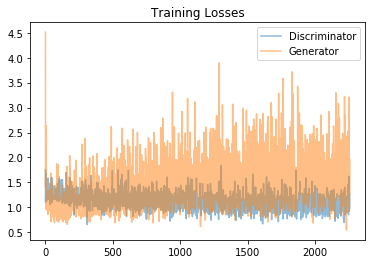

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

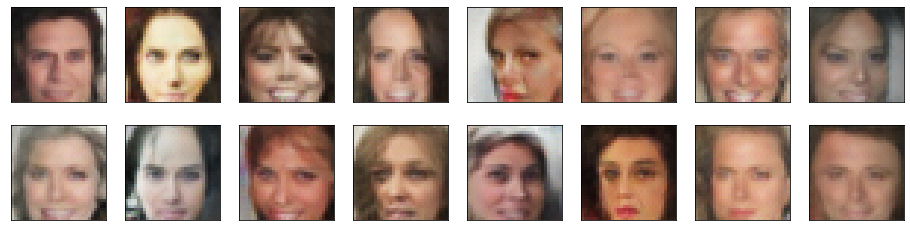

In [27]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.